**Instruction for POS Tagging Using RNNs with Arabic Dataset**

**Dataset:**
The dataset provided is named "Assignment 2 - Arabic POS.conllu". It contains labeled data for Arabic text with Part-of-Speech (POS) tags in CoNLL-U format.

**Objective:**
Your objective is to perform Part-of-Speech (POS) tagging on Arabic text using Recurrent Neural Networks (RNNs). Specifically, you will use the Universal POS (UPOS) tags for tagging. UPOS is a standardized set of POS tags that aims to cover all languages.

**Evaluation metric:**
Accuracy

**Instructions:**
1. **Data Preprocessing:**
   - Load the provided dataset "Assignment 2 - Arabic POS.conllu". You can use pyconll library
   - Preprocess the data as necessary, including tokenization

2. **Model Building:**
   - Design an RNN-based model architecture suitable for POS tagging. You may consider using recurrent layers such as (LSTM) or (GRU).
   - Define the input and output layers of the model. The input layer should accept sequences of tokens, and the output layer should produce the predicted UPOS tags for each token.

3. **Training:**

4. **Evaluation:**

**Additional Notes:**
- Make sure to document your code thoroughly and provide clear explanations for each step.
- Feel free to explore different RNN architectures, hyperparameters, and optimization techniques to improve the model's accuracy.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/NLP/Assignment_2'

Mounted at /content/drive
/content/drive/MyDrive/NLP/Assignment_2


### Import used libraries

In [2]:
!pip install pyarabic
!pip install pyconll

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 3.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import pyconll
import pyarabic.araby as araby
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate, TimeDistributed, SimpleRNN, GRU, Bidirectional
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)

### Load Dataset

In [4]:
data = pyconll.load_from_file('./Assignment 2 - Arabic POS.conllu')

## Print Sample of 10 sentences

In [5]:
i = 0
for sentence in data:
    i += 1
    print(f"Sentence: {i}")
    for token in sentence:
        print(f"ID: {token.id}, Form: {token.form}, Lemma: {token.lemma}, POS: {token.upos}")
    if i == 10:
        break

Sentence: 1
ID: 1, Form: برلين, Lemma: بَرلِين, POS: X
ID: 2, Form: ترفض, Lemma: رَفَض, POS: VERB
ID: 3, Form: حصول, Lemma: حُصُول, POS: NOUN
ID: 4, Form: شركة, Lemma: شَرِكَة, POS: NOUN
ID: 5, Form: اميركية, Lemma: أَمِيرِكِيّ, POS: ADJ
ID: 6, Form: على, Lemma: عَلَى, POS: ADP
ID: 7, Form: رخصة, Lemma: رُخصَة, POS: NOUN
ID: 8, Form: تصنيع, Lemma: تَصنِيع, POS: NOUN
ID: 9, Form: دبابة, Lemma: دَبَّابَة, POS: NOUN
ID: 10, Form: ", Lemma: ", POS: PUNCT
ID: 11, Form: ليوبارد, Lemma: لِيُوبَارد, POS: X
ID: 12, Form: ", Lemma: ", POS: PUNCT
ID: 13, Form: الالمانية, Lemma: أَلمَانِيّ, POS: ADJ
Sentence: 2
ID: 1, Form: برلين, Lemma: بَرلِين, POS: X
ID: 2, Form: 15, Lemma: 15, POS: NUM
ID: 3, Form: -, Lemma: -, POS: PUNCT
ID: 4, Form: 7, Lemma: 7, POS: NUM
ID: 5, Form: (, Lemma: (, POS: PUNCT
ID: 6, Form: اف, Lemma: اف, POS: X
ID: 7, Form: ب, Lemma: ب, POS: X
ID: 8, Form: ), Lemma: ), POS: PUNCT
ID: 9, Form: -, Lemma: -, POS: PUNCT
ID: 10, Form: افادت, Lemma: أَفَاد, POS: VERB
ID: 11, Form: صح

## Create Dataframe and add data to use to it

In [6]:
records = []

In [7]:
i = 0
for sentence in tqdm(data, desc="Filling Dataframe"):
    for token in sentence:
        new_record = {'Sentence' : i, 'Token': token.form, 'Lemma': token.lemma, 'POS': token.upos}
        records.append(new_record)
    i += 1

Filling Dataframe: 100%|██████████| 6075/6075 [00:00<00:00, 8360.71it/s]


In [8]:
df = pd.DataFrame(records)

In [9]:
df.head(20)

,Sentence,Token,Lemma,POS
0,0,برلين,بَرلِين,X
1,0,ترفض,رَفَض,VERB
2,0,حصول,حُصُول,NOUN
3,0,شركة,شَرِكَة,NOUN
4,0,اميركية,أَمِيرِكِيّ,ADJ
5,0,على,عَلَى,ADP
6,0,رخصة,رُخصَة,NOUN
7,0,تصنيع,تَصنِيع,NOUN
8,0,دبابة,دَبَّابَة,NOUN
9,0,"""","""",PUNCT


### Data splitting

In [10]:
df['Sentence'].nunique()

6075

In [11]:
df['POS'].isna().sum()

30519

In [12]:
df = df[df['POS'].notna()]

In [13]:
df['POS'].isna().sum()

0

In [14]:
df['POS'].value_counts()

POS
NOUN     74546
ADP      33617
ADJ      23498
PUNCT    17511
VERB     16789
CCONJ    15803
X        13747
PRON      8533
NUM       6010
DET       4648
SCONJ     4368
PART      1709
AUX       1699
ADV        880
SYM        329
PROPN      187
INTJ         7
Name: count, dtype: int64

In [15]:
val_test_ratio = 0.2
X_train, X_val_test, y_train, y_val_test = train_test_split(df[['Token', 'Lemma', 'Sentence']],
                                                    df['POS'],
                                                    test_size=val_test_ratio,
                                                    shuffle=False)

In [16]:
val_ratio = 0.5
X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                    y_val_test,
                                                    test_size=val_ratio,
                                                    shuffle=False)

In [17]:
train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)

train.head(10)

,Token,Lemma,Sentence,POS
0,برلين,بَرلِين,0,X
1,ترفض,رَفَض,0,VERB
2,حصول,حُصُول,0,NOUN
3,شركة,شَرِكَة,0,NOUN
4,اميركية,أَمِيرِكِيّ,0,ADJ
5,على,عَلَى,0,ADP
6,رخصة,رُخصَة,0,NOUN
7,تصنيع,تَصنِيع,0,NOUN
8,دبابة,دَبَّابَة,0,NOUN
9,"""","""",0,PUNCT


### Cleaning and Preprocessing

# `Data Cleaning`

In [18]:
train.isna().sum()

Token       0
Lemma       0
Sentence    0
POS         0
dtype: int64

In [19]:
train.duplicated().sum()

31756

In [20]:
train[train.duplicated()].head(10)

,Token,Lemma,Sentence,POS
11,"""","""",0,PUNCT
21,-,-,1,PUNCT
30,"""","""",1,PUNCT
46,"""","""",1,PUNCT
49,"""","""",1,PUNCT
56,الالمانية,أَلمَانِيّ,1,ADJ
57,"""","""",1,PUNCT
60,"""","""",1,PUNCT
63,المجموعة,مَجمُوعَة,1,NOUN
67,ل,لِ,1,ADP


In [21]:
train.drop_duplicates(inplace=True)

In [22]:
train.head(10)

,Token,Lemma,Sentence,POS
0,برلين,بَرلِين,0,X
1,ترفض,رَفَض,0,VERB
2,حصول,حُصُول,0,NOUN
3,شركة,شَرِكَة,0,NOUN
4,اميركية,أَمِيرِكِيّ,0,ADJ
5,على,عَلَى,0,ADP
6,رخصة,رُخصَة,0,NOUN
7,تصنيع,تَصنِيع,0,NOUN
8,دبابة,دَبَّابَة,0,NOUN
9,"""","""",0,PUNCT


In [23]:
class CustomLabelEncoder:
    def __init__(self, unseen_class='Not found'):
        self.label_encoder = LabelEncoder()
        self.unseen_class = unseen_class
        self.mapping = {}
        self.reverse_mapping = {}

    def fit(self, labels):
        self.label_encoder.fit(labels)
        classes = self.label_encoder.classes_

        # Create custom mappings starting from 1
        self.mapping = {label: idx + 1 for idx, label in enumerate(classes)}
        self.reverse_mapping = {idx + 1: label for idx, label in enumerate(classes)}
        self.reverse_mapping[0] = self.unseen_class

    def transform(self, labels):
        numeric_labels = [self.mapping[label] for label in labels]
        return np.array(numeric_labels)

    def inverse_transform(self, numeric_labels):
        original_labels = [self.reverse_mapping.get(label, self.unseen_class) for label in numeric_labels]
        return np.array(original_labels)


In [24]:
# Tokenizer for tokens and lemmas
token_tokenizer = Tokenizer(filters='')
lemma_tokenizer = Tokenizer(filters='')
token_tokenizer.fit_on_texts(train['Token'])
lemma_tokenizer.fit_on_texts(train['Lemma'])

# Label encoder for POS tags
pos_encoder = CustomLabelEncoder()
pos_encoder.fit(train['POS'])

# Prepare sequences
X_tokens = token_tokenizer.texts_to_sequences(train['Token'])
X_lemmas = lemma_tokenizer.texts_to_sequences(train['Lemma'])
y_pos = pos_encoder.transform(train['POS'])

In [25]:
X_tokens[:5]

[[3312], [1940], [836], [101], [1653]]

In [26]:
X_tokens = [token for tokens in X_tokens for token in tokens]
X_lemmas = [lemma for lemmas in X_lemmas for lemma in lemmas]

In [27]:
train['X_tokens'] = X_tokens
train['X_lemmas'] = X_lemmas
train['y_pos'] = y_pos

In [28]:
train.head(20)

,Token,Lemma,Sentence,POS,X_tokens,X_lemmas,y_pos
0,برلين,بَرلِين,0,X,3312,2685,17
1,ترفض,رَفَض,0,VERB,1940,299,16
2,حصول,حُصُول,0,NOUN,836,407,8
3,شركة,شَرِكَة,0,NOUN,101,29,8
4,اميركية,أَمِيرِكِيّ,0,ADJ,1653,81,1
5,على,عَلَى,0,ADP,9,8,2
6,رخصة,رُخصَة,0,NOUN,2601,1526,8
7,تصنيع,تَصنِيع,0,NOUN,1795,1104,8
8,دبابة,دَبَّابَة,0,NOUN,5528,1812,8
9,"""","""",0,PUNCT,12,13,13


In [29]:
grouped_train = train.groupby('Sentence').agg({
    'Token': list,
    'Lemma': list,
    'X_tokens': list,
    'X_lemmas': list,
    'POS': list,
    'y_pos' : list
}).reset_index()

# Rename columns to match the required format
grouped_train.rename(columns={
    'Token': 'Tokens',
    'Lemma': 'Lemmas',
    'X_tokens': 'X_tokens',
    'X_lemmas': 'X_lemmas',
    'POS': 'POSes',
    'y_pos' : 'y_poses'
}, inplace=True)

In [30]:
grouped_train.head()

,Sentence,Tokens,Lemmas,X_tokens,X_lemmas,POSes,y_poses
0,0,"[برلين, ترفض, حصول, شركة, اميركية, على, رخصة, تصنيع, دبابة, "", ليوبارد, الالمانية]","[بَرلِين, رَفَض, حُصُول, شَرِكَة, أَمِيرِكِيّ, عَلَى, رُخصَة, تَصنِيع, دَبَّابَة, "", لِيُوبَارد, أَلمَانِيّ]","[3312, 1940, 836, 101, 1653, 9, 2601, 1795, 5528, 12, 3860, 1796]","[2685, 299, 407, 29, 81, 8, 1526, 1104, 1812, 13, 2985, 619]","[X, VERB, NOUN, NOUN, ADJ, ADP, NOUN, NOUN, NOUN, PUNCT, X, ADJ]","[17, 16, 8, 8, 1, 2, 8, 8, 8, 13, 17, 1]"
1,1,"[برلين, 15, -, 7, (, اف, ب, ), افادت, صحيفة, الاحد, الالمانية, "", ويلت, ام, سونتاغ, في, عدد, ها, الصادر, غدا, ،, ان, المستشار, غيرهارد, شرودر, يرفض, حصول, المجموعة, الاميركية, جنرال, ديناميكس, على, رخصة, ل, تصنيع, الدبابة, ليوبارد, 2, عبر, شراء, الحكومية, الاسبانية, الأسلحة, سانتا, بربارة, .]","[بَرلِين, 15, -, 7, (, اف, ب, ), أَفَاد, صَحِيفَة, أَحَد, أَلمَانِيّ, "", ويلت, ام, سونتاغ, فِي, عَدَد, هُوَ, صَادِر, غَد, ،, أَنَّ, مُستَشَار, غيرهارد, شرُودِر, رَفَض, حُصُول, مَجمُوعَة, أَمِيرِكِيّ, جنرال, دِينَامِيكس, عَلَى, رُخصَة, لِ, تَصنِيع, دَبَّابَة, لِيُوبَارد, 2, عَبرَ, شِرَاء, حُكُومِيّ, إِسبَانِيّ, سِلَاح, سَانتَا, بربارة, .]","[3312, 70, 33, 419, 26, 112, 5, 27, 2922, 442, 733, 1796, 12, 10175, 4532, 10176, 3, 71, 8, 1941, 953, 7, 13, 1797, 7089, 7090, 2923, 836, 917, 213, 2924, 5529, 9, 2601, 4, 1795, 5530, 3860, 164, 355, 336, 609, 2925, 3861, 5531, 5532, 1]","[2685, 99, 36, 531, 31, 259, 132, 32, 400, 218, 144, 619, 13, 6396, 6397, 6398, 4, 72, 1, 150, 827, 10, 9, 862, 4763, 4764, 299, 407, 201, 81, 2450, 3937, 8, 1526, 5, 1104, 1812, 2985, 256, 479, 347, 371, 1186, 658, 3938, 3939, 2]","[X, NUM, PUNCT, NUM, PUNCT, X, X, PUNCT, VERB, NOUN, NOUN, ADJ, PUNCT, X, X, X, ADP, NOUN, PRON, ADJ, NOUN, PUNCT, SCONJ, NOUN, X, X, VERB, NOUN, NOUN, ADJ, X, X, ADP, NOUN, ADP, NOUN, NOUN, X, NUM, ADP, NOUN, ADJ, ADJ, NOUN, X, X, PUNCT]","[17, 9, 13, 9, 13, 17, 17, 13, 16, 8, 8, 1, 13, 17, 17, 17, 2, 8, 11, 1, 8, 13, 14, 8, 17, 17, 16, 8, 8, 1, 17, 17, 2, 8, 2, 8, 8, 17, 9, 2, 8, 1, 1, 8, 17, 17, 13]"
2,2,"[و, في, نيسان, /, ابريل, الماضي, ،, تخلت, الدولة, الاسبانية, عن, مجموعة, "", سانتا, بربارة, التي, تصنع, دبابات, ليوبارد, الالمانية, الى, جنرال, ديناميكس, التي, تنتج, الدبابة, الاميركية, ام, 1, ابرامس, المعتبرة, المنافسة, الرئيسية, ل, دبابة, الاسواق, .]","[وَ, فِي, نِيسَان, /, أَبرِيل, مَاضِي, ،, تَخَلَّى, دَولَة, إِسبَانِيّ, عَن, مَجمُوعَة, "", سَانتَا, بربارة, اَلَّذِي, صَنَع, دَبَّابَة, لِيُوبَارد, أَلمَانِيّ, إِلَى, جنرال, دِينَامِيكس, التي, أَنتَج, دَبَّابَة, أَمِيرِكِيّ, إِم, 1, أَبرَامس, مُعتَبَر, مُنَافِسَة, رَئِيسِيّ, لِ, دَبَّابَة, سُوق, .]","[2, 3, 2926, 45, 2602, 61, 7, 10177, 116, 2925, 17, 235, 12, 5531, 5532, 14, 10178, 4533, 3860, 1796, 16, 2924, 5529, 14, 3313, 5530, 213, 4532, 541, 10179, 7091, 801, 802, 4, 5528, 2603, 1]","[3, 4, 2451, 59, 1614, 63, 10, 2452, 30, 1186, 16, 201, 13, 3938, 3939, 12, 2258, 1812, 2985, 619, 11, 2450, 3937, 532, 1813, 1812, 81, 3940, 659, 6399, 3941, 2986, 437, 5, 1812, 54, 2]","[CCONJ, ADP, NOUN, PUNCT, NOUN, ADJ, PUNCT, VERB, NOUN, ADJ, ADP, NOUN, PUNCT, X, X, DET, VERB, NOUN, X, ADJ, ADP, X, X, X, VERB, NOUN, ADJ, X, NUM, X, ADJ, NOUN, ADJ, ADP, NOUN, NOUN, PUNCT]","[5, 2, 8, 13, 8, 1, 13, 16, 8, 1, 2, 8, 13, 17, 17, 6, 16, 8, 17, 1, 2, 17, 17, 17, 16, 8, 1, 17, 9, 17, 1, 8, 1, 2, 8, 8, 13]"
3,3,"[و, كانت, خسائر, المجموعة, الاسبانية, الرسمية, تراكمت, في, السنوات, العشر, الاخيرة, ل, تبلغ, 920, مليون, يورو, .]","[وَ, كَان, خَسَارَة, مَجمُوعَة, إِسبَانِيّ, رَسمِيّ, تَرَاكَم, فِي, سَنَة, عَشَرَة, أَخِير, لِ, بَلَغ, 920, مِليُون, يُورُو, .]","[2, 63, 632, 917, 2925, 518, 7092, 3, 837, 2927, 734, 4, 591, 7093, 48, 1352, 1]","[3, 15, 365, 201, 1186, 188, 3412, 4, 88, 359, 137, 5, 115, 4765, 39, 747, 2]","[CCONJ, VERB, NOUN, NOUN, ADJ, ADJ, VERB, ADP, NOUN, NUM, ADJ, CCONJ, VERB, NUM, NUM, NOUN, PUNCT]","[5, 16, 8, 8, 1, 1, 16, 2, 8, 9, 1, 5, 16, 9, 9, 8, 13]"
4,4,"[و, أشارت, صحيفة, الاحد, الى, ان, المستشار, شرودر, يعتبر, حصول, المجموعة, الاميركية, على, رخصة, تصنيع, ليوبارد, 2, يعرض, ل, الخطر, ال

In [31]:
ser = grouped_train['Tokens'].apply(lambda x: len(x))
ser.describe()

count    4649.000000
mean       31.694558
std        19.826660
min         1.000000
25%        17.000000
50%        30.000000
75%        42.000000
max       227.000000
Name: Tokens, dtype: float64

<Axes: ylabel='Tokens'>

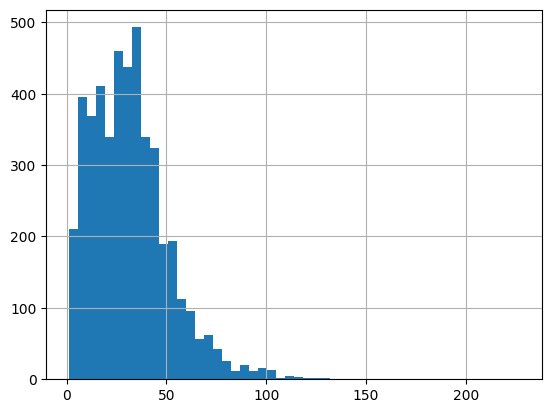

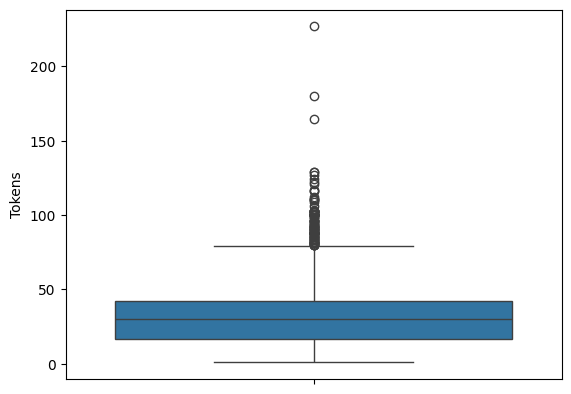

In [32]:
plt.figure()
ser.hist(bins=50)
plt.figure()
sns.boxplot(ser)

In [33]:
max_len = 100
X_tokens_pad = pad_sequences(grouped_train['X_tokens'], maxlen=max_len, padding='post')
X_lemmas_pad = pad_sequences(grouped_train['X_lemmas'], maxlen=max_len, padding='post')
y_pos = pad_sequences(grouped_train['y_poses'], maxlen=max_len, padding='post')


X_tokens_pad = np.array(X_tokens_pad)
X_lemmas_pad = np.array(X_lemmas_pad)
y_pos = np.array(y_pos)

### Modelling

In [41]:
def build_rnn_model(input_dim, output_dim, input_length, Network=SimpleRNN):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length),
        Network(128, return_sequences=True),
        TimeDistributed(Dense(output_dim, activation='softmax'))
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [35]:
def my_pipe_line(df, token_tokenizer, lemma_tokenizer, pos_encoder):
  X_tokens = token_tokenizer.texts_to_sequences(df['Token'])
  X_lemmas = lemma_tokenizer.texts_to_sequences(df['Token'])
  X_tokens = [token for tokens in X_tokens for token in (tokens if tokens else [0])]
  X_lemmas = [lemma for lemmas in X_lemmas for lemma in (lemmas if lemmas else [0])]
  y_pos = pos_encoder.transform(df['POS']) - 1
  df['X_tokens'] = X_tokens
  df['X_lemmas'] = X_lemmas
  df['y_pos'] = y_pos + 1
  grouped_df = df.groupby('Sentence').agg({
      'Token': list,
      'Lemma': list,
      'X_tokens': list,
      'X_lemmas': list,
      'POS': list,
      'y_pos' : list
  }).reset_index()

  grouped_df.rename(columns={
      'Token': 'Tokens',
      'Lemma': 'Lemmas',
      'X_tokens': 'X_tokens',
      'X_lemmas': 'X_lemmas',
      'POS': 'POSes',
      'y_pos' : 'y_poses'
  }, inplace=True)
  X_tokens_pad = pad_sequences(grouped_df['X_tokens'], maxlen=max_len, padding='post')
  X_lemmas_pad = pad_sequences(grouped_df['X_lemmas'], maxlen=max_len, padding='post')
  y_pos = pad_sequences(grouped_df['y_poses'], maxlen=max_len, padding='post')

  return X_tokens_pad, X_lemmas_pad, y_pos, grouped_df


In [36]:
val_tokens_pad, val_lemmas_pad, y_val_pad, val_df = my_pipe_line(val, token_tokenizer, lemma_tokenizer, pos_encoder)
test_tokens_pad, test_lemmas_pad, y_test_pad, test_df = my_pipe_line(test, token_tokenizer, lemma_tokenizer, pos_encoder)

In [348]:
# output_dim should be greater than number of POSes
model = build_rnn_model(input_dim=len(token_tokenizer.word_index) + 1, output_dim=64, input_length=None, Network=SimpleRNN)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, None, 64)          1237568   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 128)         24704     
                                                                 
 time_distributed_18 (TimeD  (None, None, 64)          8256      
 istributed)                                                     
                                                                 
Total params: 1270528 (4.85 MB)
Trainable params: 1270528 (4.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [309]:
print(val_tokens_pad.shape)
print(y_val_pad.shape)
print(X_tokens_pad.shape)
print(y_pos.shape)

(682, 100)
(682, 100)
(4649, 100)
(4649, 100)


In [349]:
history = model.fit(X_tokens_pad, y_pos, epochs=10, batch_size=128, validation_data=(val_tokens_pad, y_val_pad), validation_steps=1)

Epoch 1/10
37/37 [==============================] - 9s 200ms/step - loss: 1.9820 - accuracy: 0.6381 - val_loss: 1.7277 - val_accuracy: 0.5641
Epoch 2/10
37/37 [==============================] - 10s 272ms/step - loss: 1.0779 - accuracy: 0.7248 - val_loss: 1.1328 - val_accuracy: 0.6875
Epoch 3/10
37/37 [==============================] - 7s 194ms/step - loss: 0.7628 - accuracy: 0.7873 - val_loss: 1.0399 - val_accuracy: 0.6963
Epoch 4/10
37/37 [==============================] - 10s 267ms/step - loss: 0.7004 - accuracy: 0.7962 - val_loss: 0.9582 - val_accuracy: 0.7105
Epoch 5/10
37/37 [==============================] - 8s 217ms/step - loss: 0.6264 - accuracy: 0.8058 - val_loss: 0.8876 - val_accuracy: 0.7332
Epoch 6/10
37/37 [==============================] - 9s 250ms/step - loss: 0.5398 - accuracy: 0.8495 - val_loss: 0.7356 - val_accuracy: 0.8084
Epoch 7/10
37/37 [==============================] - 9s 234ms/step - loss: 0.4296 - accuracy: 0.8901 - val_loss: 0.5774 - val_accuracy: 0.8562
Epoc

In [350]:
def metrics_plot(model_name):
  acc = model_name.history['accuracy']
  val_acc = model_name.history['val_accuracy']
  loss = model_name.history['loss']
  val_loss = model_name.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')

  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

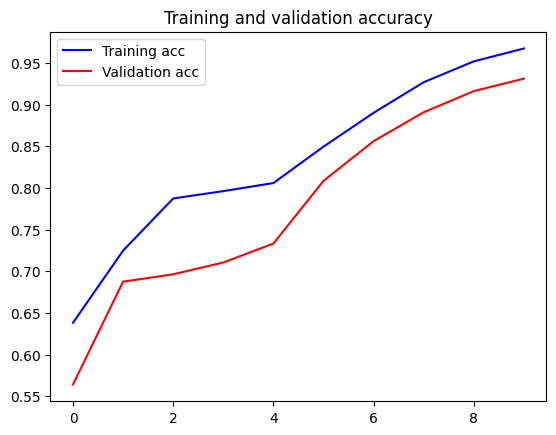

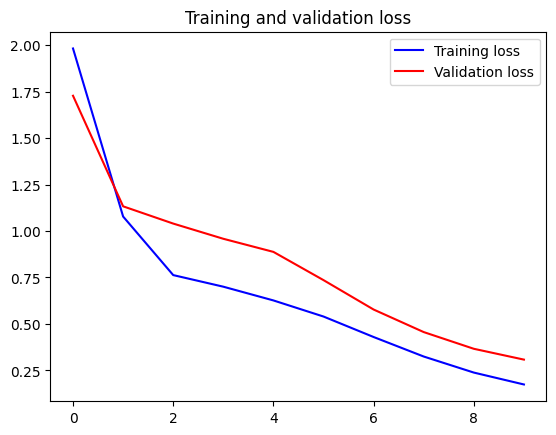

In [351]:
metrics_plot(history)

#### Evaluation

**Evaluation metric:**
Accuracy

In [352]:
loss, accuracy = model.evaluate(test_tokens_pad, y_test_pad)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

24/24 [==============================] - 1s 35ms/step - loss: 0.3688 - accuracy: 0.9062
Test Loss: 0.36883020401000977
Test Accuracy: 0.9062198400497437


# Test Model :

In [353]:
predictions = model.predict(test_tokens_pad[:5])

1/1 [==============================] - 0s 219ms/step


In [354]:
predictions.shape

(5, 100, 64)

In [355]:
predictions[0]

array([[1.00918012e-02, 2.06939112e-02, 1.80465747e-02, ...,
        1.20794401e-02, 1.53051643e-02, 1.45045472e-02],
       [6.64603990e-03, 3.12655687e-01, 1.16003631e-02, ...,
        1.06113004e-02, 1.54499905e-02, 1.11911828e-02],
       [1.29716964e-02, 2.97416914e-02, 2.16629580e-02, ...,
        2.01121904e-02, 1.54379299e-02, 1.29045034e-02],
       ...,
       [9.98432875e-01, 3.03103661e-05, 2.23030893e-05, ...,
        6.16760701e-07, 1.88659740e-07, 3.63022622e-07],
       [9.98432875e-01, 3.03103661e-05, 2.23031093e-05, ...,
        6.16761895e-07, 1.88659740e-07, 3.63022622e-07],
       [9.98432875e-01, 3.03103661e-05, 2.23030893e-05, ...,
        6.16761326e-07, 1.88659740e-07, 3.63022622e-07]], dtype=float32)

In [356]:
max_indices = np.argmax(predictions[0], axis=1)

In [357]:
max_indices

array([ 8,  1, 35,  5,  8,  2,  8,  8, 13,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [358]:
y_test_pad[0]

array([ 8,  1,  1,  5,  8,  2,  8,  8, 13,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [359]:
original_labels = pos_encoder.inverse_transform(max_indices)
original_labels

array(['NOUN', 'ADJ', 'Not found', 'CCONJ', 'NOUN', 'ADP', 'NOUN', 'NOUN',
       'PUNCT', 'Not found', 'Not found', 'Not found', 'Not found',
       'Not found', 'Not found', 'Not found', 'Not found', 'Not found',
       'Not found', 'Not found', 'Not found', 'Not found', 'Not found',
       'Not found', 'Not found', 'Not found', 'Not found', 'Not found',
       'Not found', 'Not found', 'Not found', 'Not found', 'Not found',
       'Not found', 'Not found', 'Not found', 'Not found', 'Not found',
       'Not found', 'Not found', 'Not found', 'Not found', 'Not found',
       'Not found', 'Not found', 'Not found', 'Not found', 'Not found',
       'Not found', 'Not found', 'Not found', 'Not found', 'Not found',
       'Not found', 'Not found', 'Not found', 'Not found', 'Not found',
       'Not found', 'Not found', 'Not found', 'Not found', 'Not found',
       'Not found', 'Not found', 'Not found', 'Not found', 'Not found',
       'Not found', 'Not found', 'Not found', 'Not found', 'Not f

# Another Sample :


In [360]:
predictions[1][1]

array([3.4702539e-01, 3.5598893e-03, 5.8853291e-03, 5.6400369e-03,
       1.1530393e-02, 4.7412902e-02, 1.5240202e-03, 9.1696210e-04,
       6.6205407e-03, 1.7128993e-02, 2.6370481e-02, 2.2331565e-03,
       1.3268904e-03, 4.5334395e-02, 1.2998465e-02, 1.1648174e-03,
       3.9246288e-01, 2.6472043e-02, 1.4697342e-03, 1.1996954e-03,
       6.2168931e-04, 3.6546323e-04, 1.2527256e-03, 1.2354864e-03,
       2.2422583e-03, 1.4277659e-03, 6.6788995e-04, 5.4712471e-04,
       1.1629582e-03, 4.7182373e-04, 6.7950843e-04, 6.8296015e-04,
       6.0012692e-04, 7.7917095e-04, 1.1216966e-03, 4.4318283e-04,
       7.1012083e-04, 1.4063176e-03, 9.8927738e-04, 6.2434131e-04,
       8.6991553e-04, 1.0280374e-03, 4.3837418e-04, 1.0748613e-03,
       1.0324653e-03, 1.3122868e-03, 7.0032594e-04, 1.3056587e-03,
       1.1617483e-03, 3.5647489e-04, 1.6261231e-03, 1.6382253e-03,
       2.9743192e-04, 2.1927920e-03, 8.0218143e-04, 7.6059689e-04,
       7.4383413e-04, 8.7037153e-04, 4.9230963e-04, 4.5583770e

In [361]:
max_indices = np.argmax(predictions[4], axis=1)
max_indices

array([ 8,  8, 17,  1, 17, 17, 17,  8,  8,  8,  1,  1,  8,  8,  8,  2,  8,
       11, 16, 17,  0,  0,  2,  8,  8,  2,  8, 17,  8,  1,  2,  8, 13,  5,
       16,  8,  8,  8, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [362]:
y_test_pad[4]

array([16, 17, 17, 12, 17, 17, 17,  8,  8,  8,  1,  1,  8,  8,  8,  2,  8,
       11,  1,  8, 17, 16,  2,  8, 17,  2,  8,  5,  8,  1,  2,  8, 13,  5,
       16,  8, 17,  8, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [363]:
pos_encoder.inverse_transform(max_indices)

array(['NOUN', 'NOUN', 'X', 'ADJ', 'X', 'X', 'X', 'NOUN', 'NOUN', 'NOUN',
       'ADJ', 'ADJ', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'PRON',
       'VERB', 'X', 'Not found', 'Not found', 'ADP', 'NOUN', 'NOUN',
       'ADP', 'NOUN', 'X', 'NOUN', 'ADJ', 'ADP', 'NOUN', 'PUNCT', 'CCONJ',
       'VERB', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'Not found', 'Not found',
       'Not found', 'Not found', 'Not found', 'Not found', 'Not found',
       'Not found', 'Not found', 'Not found', 'Not found', 'Not found',
       'Not found', 'Not found', 'Not found', 'Not found', 'Not found',
       'Not found', 'Not found', 'Not found', 'Not found', 'Not found',
       'Not found', 'Not found', 'Not found', 'Not found', 'Not found',
       'Not found', 'Not found', 'Not found', 'Not found', 'Not found',
       'Not found', 'Not found', 'Not found', 'Not found', 'Not found',
       'Not found', 'Not found', 'Not found', 'Not found', 'Not found',
       'Not found', 'Not found', 'Not found', 'Not found', 'Not 

### Enhancement

In [364]:
# 1- Using GRU
model2 = build_rnn_model(input_dim=len(token_tokenizer.word_index) + 1, output_dim=64, input_length=None, Network=GRU)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, None, 64)          1237568   
                                                                 
 gru (GRU)                   (None, None, 128)         74496     
                                                                 
 time_distributed_19 (TimeD  (None, None, 64)          8256      
 istributed)                                                     
                                                                 
Total params: 1320320 (5.04 MB)
Trainable params: 1320320 (5.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [365]:
history2 = model2.fit(X_tokens_pad, y_pos, epochs=10, batch_size=128, validation_data=(val_tokens_pad, y_val_pad), validation_steps=1)

Epoch 1/10
37/37 [==============================] - 19s 442ms/step - loss: 2.3397 - accuracy: 0.6667 - val_loss: 1.6033 - val_accuracy: 0.5604
Epoch 2/10
37/37 [==============================] - 20s 553ms/step - loss: 1.0161 - accuracy: 0.6965 - val_loss: 1.2198 - val_accuracy: 0.6478
Epoch 3/10
37/37 [==============================] - 25s 656ms/step - loss: 0.7645 - accuracy: 0.7946 - val_loss: 1.0927 - val_accuracy: 0.6840
Epoch 4/10
37/37 [==============================] - 23s 612ms/step - loss: 0.6687 - accuracy: 0.7995 - val_loss: 1.0587 - val_accuracy: 0.6895
Epoch 5/10
37/37 [==============================] - 22s 590ms/step - loss: 0.6099 - accuracy: 0.8075 - val_loss: 0.9236 - val_accuracy: 0.7049
Epoch 6/10
37/37 [==============================] - 16s 421ms/step - loss: 0.5122 - accuracy: 0.8351 - val_loss: 0.6946 - val_accuracy: 0.8120
Epoch 7/10
37/37 [==============================] - 19s 496ms/step - loss: 0.3653 - accuracy: 0.9005 - val_loss: 0.4611 - val_accuracy: 0.8866

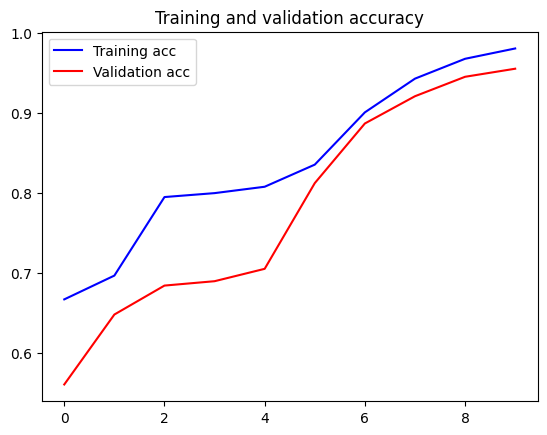

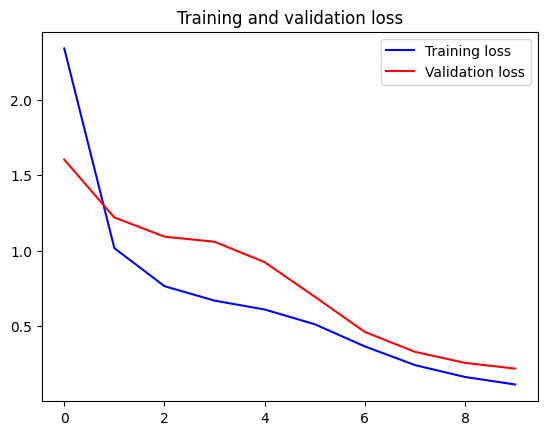

In [366]:
metrics_plot(history2)

In [370]:
loss, accuracy = model2.evaluate(test_tokens_pad, y_test_pad)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

24/24 [==============================] - 2s 93ms/step - loss: 0.2271 - accuracy: 0.9434
Test Loss: 0.22707514464855194
Test Accuracy: 0.9434450268745422


In [367]:
# 2- Using LSTM
model3 = build_rnn_model(input_dim=len(token_tokenizer.word_index) + 1, output_dim=64, input_length=None, Network=LSTM)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, None, 64)          1237568   
                                                                 
 lstm_17 (LSTM)              (None, None, 128)         98816     
                                                                 
 time_distributed_20 (TimeD  (None, None, 64)          8256      
 istributed)                                                     
                                                                 
Total params: 1344640 (5.13 MB)
Trainable params: 1344640 (5.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [368]:
history3 = model3.fit(X_tokens_pad, y_pos, epochs=10, batch_size=128, validation_data=(val_tokens_pad, y_val_pad), validation_steps=1)

Epoch 1/10
37/37 [==============================] - 21s 500ms/step - loss: 2.1143 - accuracy: 0.6664 - val_loss: 1.7396 - val_accuracy: 0.5623
Epoch 2/10
37/37 [==============================] - 18s 500ms/step - loss: 1.1974 - accuracy: 0.6860 - val_loss: 1.4103 - val_accuracy: 0.5777
Epoch 3/10
37/37 [==============================] - 19s 505ms/step - loss: 0.8653 - accuracy: 0.7689 - val_loss: 1.1311 - val_accuracy: 0.6852
Epoch 4/10
37/37 [==============================] - 19s 499ms/step - loss: 0.7397 - accuracy: 0.7943 - val_loss: 1.2100 - val_accuracy: 0.6802
Epoch 5/10
37/37 [==============================] - 18s 498ms/step - loss: 0.6956 - accuracy: 0.7978 - val_loss: 1.1624 - val_accuracy: 0.6851
Epoch 6/10
37/37 [==============================] - 18s 497ms/step - loss: 0.6616 - accuracy: 0.8008 - val_loss: 1.0935 - val_accuracy: 0.6916
Epoch 7/10
37/37 [==============================] - 18s 497ms/step - loss: 0.6172 - accuracy: 0.8072 - val_loss: 0.9434 - val_accuracy: 0.7067

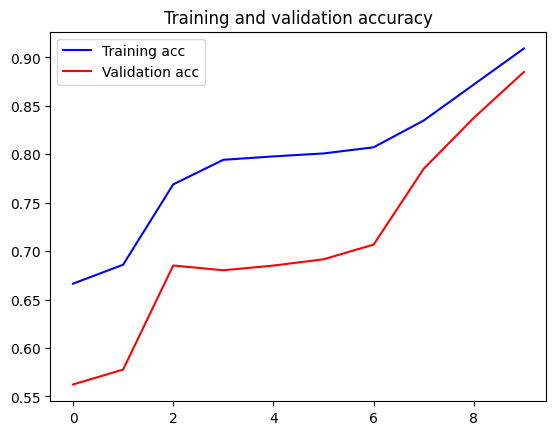

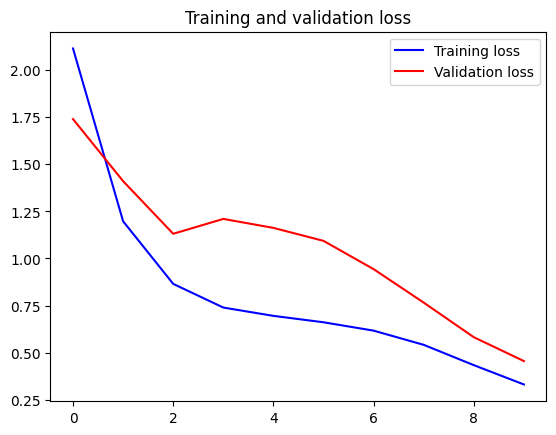

In [369]:
metrics_plot(history3)

In [371]:
loss, accuracy = model3.evaluate(test_tokens_pad, y_test_pad)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

24/24 [==============================] - 2s 70ms/step - loss: 0.3869 - accuracy: 0.8920
Test Loss: 0.3868880271911621
Test Accuracy: 0.8919571042060852


# Making Bi-Directional model

In [373]:
def build_bi_rnn_model(input_dim, output_dim, input_length, Network=SimpleRNN):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length),
        Bidirectional(Network(128, return_sequences=True)),
        TimeDistributed(Dense(output_dim, activation='softmax'))
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [374]:
# 1- Simple RNN :
model1_bi = build_bi_rnn_model(input_dim=len(token_tokenizer.word_index) + 1, output_dim=64, input_length=None, Network=LSTM)

# 2- GRU :
model2_bi = build_bi_rnn_model(input_dim=len(token_tokenizer.word_index) + 1, output_dim=64, input_length=None, Network=GRU)

# 3- LSTM :
model3_bi = build_bi_rnn_model(input_dim=len(token_tokenizer.word_index) + 1, output_dim=64, input_length=None, Network=LSTM)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, None, 64)          1237568   
                                                                 
 bidirectional (Bidirection  (None, None, 256)         197632    
 al)                                                             
                                                                 
 time_distributed_21 (TimeD  (None, None, 64)          16448     
 istributed)                                                     
                                                                 
Total params: 1451648 (5.54 MB)
Trainable params: 1451648 (5.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape            

In [375]:
history1_bi = model1_bi.fit(X_tokens_pad, y_pos, epochs=10, batch_size=128, validation_data=(val_tokens_pad, y_val_pad), validation_steps=1)

Epoch 1/10
37/37 [==============================] - 40s 943ms/step - loss: 1.8829 - accuracy: 0.6987 - val_loss: 1.3386 - val_accuracy: 0.6585
Epoch 2/10
37/37 [==============================] - 32s 860ms/step - loss: 0.7603 - accuracy: 0.7942 - val_loss: 1.1198 - val_accuracy: 0.6946
Epoch 3/10
37/37 [==============================] - 31s 817ms/step - loss: 0.6978 - accuracy: 0.7961 - val_loss: 1.1162 - val_accuracy: 0.6973
Epoch 4/10
37/37 [==============================] - 35s 930ms/step - loss: 0.6678 - accuracy: 0.7999 - val_loss: 1.1244 - val_accuracy: 0.7001
Epoch 5/10
37/37 [==============================] - 31s 841ms/step - loss: 0.6472 - accuracy: 0.8019 - val_loss: 1.1086 - val_accuracy: 0.7035
Epoch 6/10
37/37 [==============================] - 31s 844ms/step - loss: 0.6222 - accuracy: 0.8049 - val_loss: 1.0170 - val_accuracy: 0.7055
Epoch 7/10
37/37 [==============================] - 31s 826ms/step - loss: 0.5682 - accuracy: 0.8123 - val_loss: 0.7792 - val_accuracy: 0.7507

In [376]:
history2_bi = model2_bi.fit(X_tokens_pad, y_pos, epochs=10, batch_size=128, validation_data=(val_tokens_pad, y_val_pad), validation_steps=1)

Epoch 1/10
37/37 [==============================] - 35s 800ms/step - loss: 2.1178 - accuracy: 0.6660 - val_loss: 1.5150 - val_accuracy: 0.5598
Epoch 2/10
37/37 [==============================] - 30s 809ms/step - loss: 0.8958 - accuracy: 0.7168 - val_loss: 1.0294 - val_accuracy: 0.7039
Epoch 3/10
37/37 [==============================] - 28s 761ms/step - loss: 0.6631 - accuracy: 0.8020 - val_loss: 1.0728 - val_accuracy: 0.6864
Epoch 4/10
37/37 [==============================] - 27s 726ms/step - loss: 0.5690 - accuracy: 0.8195 - val_loss: 0.8478 - val_accuracy: 0.7673
Epoch 5/10
37/37 [==============================] - 29s 776ms/step - loss: 0.4125 - accuracy: 0.8753 - val_loss: 0.5260 - val_accuracy: 0.8541
Epoch 6/10
37/37 [==============================] - 28s 766ms/step - loss: 0.2427 - accuracy: 0.9411 - val_loss: 0.2907 - val_accuracy: 0.9391
Epoch 7/10
37/37 [==============================] - 27s 720ms/step - loss: 0.1383 - accuracy: 0.9726 - val_loss: 0.1993 - val_accuracy: 0.9600

In [377]:
history3_bi = model3_bi.fit(X_tokens_pad, y_pos, epochs=10, batch_size=128, validation_data=(val_tokens_pad, y_val_pad), validation_steps=1)

Epoch 1/10
37/37 [==============================] - 56s 1s/step - loss: 1.7939 - accuracy: 0.6996 - val_loss: 1.3285 - val_accuracy: 0.6658
Epoch 2/10
37/37 [==============================] - 43s 1s/step - loss: 0.7588 - accuracy: 0.7896 - val_loss: 1.1581 - val_accuracy: 0.6942
Epoch 3/10
37/37 [==============================] - 31s 848ms/step - loss: 0.6992 - accuracy: 0.7947 - val_loss: 1.0235 - val_accuracy: 0.7028
Epoch 4/10
37/37 [==============================] - 31s 833ms/step - loss: 0.6715 - accuracy: 0.7986 - val_loss: 1.1565 - val_accuracy: 0.6986
Epoch 5/10
37/37 [==============================] - 32s 881ms/step - loss: 0.6508 - accuracy: 0.8003 - val_loss: 0.9313 - val_accuracy: 0.7122
Epoch 6/10
37/37 [==============================] - 31s 834ms/step - loss: 0.6260 - accuracy: 0.8043 - val_loss: 0.8947 - val_accuracy: 0.7148
Epoch 7/10
37/37 [==============================] - 31s 826ms/step - loss: 0.5766 - accuracy: 0.8221 - val_loss: 0.7729 - val_accuracy: 0.7859
Epoch

In [378]:
print("Bi-Simple RNN")
loss, accuracy = model1_bi.evaluate(test_tokens_pad, y_test_pad)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print('_' * 73)

print("Bi-GRU")
loss, accuracy = model2_bi.evaluate(test_tokens_pad, y_test_pad)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print('_' * 73)

print("Bi-LSTM")
loss, accuracy = model3_bi.evaluate(test_tokens_pad, y_test_pad)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print('_' * 73)

Bi-Simple RNN
24/24 [==============================] - 4s 147ms/step - loss: 0.2844 - accuracy: 0.9304
Test Loss: 0.2843877375125885
Test Accuracy: 0.9304155707359314
_________________________________________________________________________
Bi-GRU
24/24 [==============================] - 2s 64ms/step - loss: 0.1635 - accuracy: 0.9586
Test Loss: 0.16349530220031738
Test Accuracy: 0.9585657119750977
_________________________________________________________________________
Bi-LSTM
24/24 [==============================] - 2s 91ms/step - loss: 0.2853 - accuracy: 0.9269
Test Loss: 0.28529930114746094
Test Accuracy: 0.9268766641616821
_________________________________________________________________________


# Optimization Using ❤️ OPTUNA ❤️

In [37]:
!pip install optuna


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.4 MB/s eta 0:00:00


In [42]:
import optuna
def objective(trial):
    output_dim = trial.suggest_categorical('output_dim', [32, 64, 128])
    network_type = trial.suggest_categorical('Network', ['SimpleRNN', 'GRU', 'LSTM'])
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])

    if network_type == 'SimpleRNN':
        Network = SimpleRNN
    elif network_type == 'GRU':
        Network = GRU
    else:
        Network = LSTM

    model = build_rnn_model(input_dim=len(token_tokenizer.word_index) + 1,
                            output_dim=output_dim,
                            input_length=None,
                            Network=Network)

    history = model.fit(X_tokens_pad, y_pos,
                        epochs=5,
                        batch_size=batch_size,
                        validation_data=(val_tokens_pad, y_val_pad),
                        validation_steps=1,
                        verbose=0)

    val_loss = history.history['val_loss'][-1]

    return val_loss

study = optuna.create_study(direction='minimize')

study.optimize(objective, n_trials=20)

print("Best hyperparameters: ", study.best_params)


[I 2024-05-21 12:22:54,624] A new study created in memory with name: no-name-8f37eda6-87df-4aa6-8b08-3f626e74c0bc
[I 2024-05-21 12:23:38,502] Trial 0 finished with value: 0.2282189130783081 and parameters: {'output_dim': 128, 'Network': 'GRU', 'batch_size': 64}. Best is trial 0 with value: 0.2282189130783081.
[I 2024-05-21 12:24:11,476] Trial 1 finished with value: 1.0313458442687988 and parameters: {'output_dim': 32, 'Network': 'GRU', 'batch_size': 128}. Best is trial 0 with value: 0.2282189130783081.
[I 2024-05-21 12:24:53,227] Trial 2 finished with value: 0.24118973314762115 and parameters: {'output_dim': 64, 'Network': 'GRU', 'batch_size': 64}. Best is trial 0 with value: 0.2282189130783081.
[I 2024-05-21 12:25:13,176] Trial 3 finished with value: 1.4294023513793945 and parameters: {'output_dim': 32, 'Network': 'LSTM', 'batch_size': 256}. Best is trial 0 with value: 0.2282189130783081.
[I 2024-05-21 12:25:55,278] Trial 4 finished with value: 1.0098556280136108 and parameters: {'out

Best hyperparameters:  {'output_dim': 128, 'Network': 'GRU', 'batch_size': 64}


### Conclusion and final results


In [43]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [44]:
optuna.visualization.plot_parallel_coordinate(study, params=['output_dim', 'Network', "batch_size"])
optuna.visualization.plot_param_importances(study)

In [45]:
print("Best hyperparameters: ", study.best_params)

Best hyperparameters:  {'output_dim': 128, 'Network': 'GRU', 'batch_size': 64}


As conclusion :

1. We read data from conllu file
2. Put Data into dataframe
3. Split Data , Clean data (Remove nulls and duplicated)
4. Tokenize each word in train data and give it a unique index
5. Labelling different POS
6. Embedding Layer to embed each work to a repreaentative vector
7. Applying (SimpleRNN, GRU, LSTM) all with dipth "128" layer
8. Doing Hyper-parameter tuning and realizing that best results are :
    - Embedding Size = 64
    - Network : GRU
    - Batch Size = 64
9. Optuna optimization tell us that over all hyper parameters, the most important in (Batch Size)

#### Done!